In [111]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the config file
import config

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# for Google Geocoding API
'''
Setting up the API key and getting started was enabled with help from the following sources:
* https://developers.google.com/maps/documentation/geocoding/?csw=1
* https://developers.google.com/maps/documentation/geocoding/overview
* https://developers.google.com/maps/get-started#api-key
* https://developers.google.com/maps/documentation/geocoding/get-api-key
* https://github.com/googlemaps/google-maps-services-python
'''
import googlemaps
from datetime import datetime

# Import the Beatiful Soup and Requests Packages for web scraping:
import requests
from bs4 import BeautifulSoup

# Need to import time to add waits/pauses:
import time

# Copy Over Functions From Previous Notebooks

In [237]:
'''
The col_logger function will need to be brough in from the other notebooks

This has been modified to include a 0 imputation value n such that transforamtion
occurs on log(n) and not log(0) which is undefined.
'''

def col_logger(data_column, zero_imp = 1):
    # Since log(0) is undefined, 0's must be treated as log(1)
    return data_column.apply(lambda x: np.log(zero_imp) if x==0 else np.log(x))

In [231]:
# This funciton was written around the following source:
# https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d

def min_dist(fn_lat, fn_lng):
    
    # Set a minimum distnace well beyond anything that would be derived
    min_dist = 90
    
    # Write a loop to find the minimum (euclidean) distance to every T-stop
    for n in range(len(latitudes)):
        dist = ((fn_lat - latitudes[n])**2 + (fn_lng - longitudes[n])**2)**0.5
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

In [229]:
# Create a more advanced 'plot vs' function which examines logs too

def plot_vs_log(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    # calculate the correlations
    #  Source for correlation:  https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
    
    # NaNs need to be dropped, in doing that, the array dimensions must match
    #  To do that, indices will be compared to get the intersection of index values
    #  Help with this from:  https://realpython.com/numpy-scipy-pandas-correlation-python/#pearson-correlation-coefficient
    base_corr = round(pd.DataFrame([data_x, data_y]).T.corr().iloc[0][1], 3)
    y_log_corr = round(pd.DataFrame([data_x, col_logger(data_y)]).T.corr().iloc[0][1], 3)
    x_y_log_corr = round(pd.DataFrame([col_logger(data_x), col_logger(data_y)]).T.corr().iloc[0][1], 3)
    
    plt.figure(figsize = size)
    
    # Untransformed variables
    plt.subplot(1, 3, 1)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} \nvs. {data_x.name} \ncorr: {base_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    # For log scaale, source for help:  https://www.geeksforgeeks.org/how-to-plot-logarithmic-axes-in-matplotlib/
    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    
    # Log transform y (adjust the axis scale)
    plt.subplot(1, 3, 2)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. {data_x.name}\ncorr: {y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    plt.yscale('log')

    # Log transform BOTH x and y (adjust the axis scales)
    plt.subplot(1, 3, 3)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. Log {data_x.name}\ncorr: {x_y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'log {data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    plt.xscale('log')
    plt.yscale('log')

# Find Proximity to Subway ('T') Stations

## Get a List of Sll the T Stations/Stops

Web scrape this entire site:  https://www.mbta.com/stops/subway .... to get the list of stations, then go to the urls for each to get the address and scrape the address which will get entered into the google geocoding request

In [89]:
# Store the base url from which all T-stop data will be retrieved
base_url = 'https://www.mbta.com/stops/subway'

# Connect to the web page:
res = requests.get(base_url)

# Pull the website text HTML string out
html = res.text

# Create that Beautiful Soup Instance!  Choosing 'lxml' as the parser.
soup = BeautifulSoup(html, 'lxml')

res.status_code

200

In [93]:
# From the site code, the urls for the stops are under the class specified below
a_list = soup.find_all('a', {'class': 'btn button stop-btn m-detailed-stop'})

# The href is then the url for each stop
stn_urls = [station['href'] for station in a_list]
print(len(stn_urls))
stn_urls

132


['/stops/place-alfcl',
 '/stops/place-andrw',
 '/stops/place-asmnl',
 '/stops/place-brntn',
 '/stops/place-brdwy',
 '/stops/place-cntsq',
 '/stops/place-chmnl',
 '/stops/place-davis',
 '/stops/place-dwnxg',
 '/stops/place-fldcr',
 '/stops/place-harsq',
 '/stops/place-jfk',
 '/stops/place-knncl',
 '/stops/place-nqncy',
 '/stops/place-pktrm',
 '/stops/place-portr',
 '/stops/place-qamnl',
 '/stops/place-qnctr',
 '/stops/place-shmnl',
 '/stops/place-smmnl',
 '/stops/place-sstat',
 '/stops/place-wlsta',
 '/stops/place-asmnl',
 '/stops/place-butlr',
 '/stops/place-capst',
 '/stops/place-cedgr',
 '/stops/place-cenav',
 '/stops/place-matt',
 '/stops/place-miltt',
 '/stops/place-valrd',
 '/stops/place-astao',
 '/stops/place-bbsta',
 '/stops/place-chncl',
 '/stops/place-ccmnl',
 '/stops/place-dwnxg',
 '/stops/place-forhl',
 '/stops/place-grnst',
 '/stops/place-haecl',
 '/stops/place-jaksn',
 '/stops/place-mlmnl',
 '/stops/place-masta',
 '/stops/place-north',
 '/stops/place-ogmnl',
 '/stops/place

In [119]:
'''
DO NOT DELETE THIS
'''



# # Create the url for the station

# '''
# For whatever reason, the base url for each specific station drops the '/stops/subway'
# portion of the base url.  This is corrected by creating a new base url
# '''
# # Create the new base url
# base_url_new = base_url.replace('/stops/subway', '')
# print(base_url_new)

# # Now take everything above and loop through it but add a wait time
#     # Source:  https://stackoverflow.com/questions/24409861/tell-python-to-wait-pause-a-for-loop

# add_list = []
    
# for station in stn_urls:
#     # Create the url for the first T-stop
#     stn_url = base_url_new + station

#     # Connect to T-stop page
#     res_stn = requests.get(stn_url)

#     # Pull the website text HTML string out for the station/t-stop
#     html_stn = res_stn.text

#     # Create the soup object
#     soup_stn = BeautifulSoup(html_stn, 'lxml')

#     # Extract the address text:
#     add_list.append(soup_stn.find_all('div', {'class': 'h3'})[0].text)
    
#     # Add a wait time of 1 second
#     time.sleep(1)

'\nDO NOT DELETE THIS\n'

In [168]:
# Store the data to a dataframe and save as a .csv in-case you get blocked
#  after needing to rerun this code multiple times.
t_stop_adrs = pd.DataFrame(pd.Series(add_list), columns = ['address'])
#t_stop_adrs.to_csv('../data/t_stop_addresses.csv', index = False)

# Geocoding API

In [130]:
# I think we need this url per the following source:
#  https://developers.google.com/maps/documentation/geocoding/get-api-key

# This is the url they give you for formatting:
    # 'https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA&key=YOUR_API_KEY'
api_key = config.api_key;

## Test Out a Request

In [131]:
# The code below was copied exactly from the following source, just ot make sure that it works:
    # https://github.com/googlemaps/google-maps-services-python

gmaps = googlemaps.Client(key=api_key)

# Geocoding an address
geocode_result = gmaps.geocode('Alewife Brook Pkwy and Cambridge Park Dr, Cambridge, MA 02140')

In [132]:
geocode_result

[{'address_components': [{'long_name': 'Alewife Brook Parkway & Cambridgepark Drive',
    'short_name': 'Alewife Brook Pkwy & Cambridgepark Dr',
    'types': ['intersection']},
   {'long_name': 'North Cambridge',
    'short_name': 'North Cambridge',
    'types': ['neighborhood', 'political']},
   {'long_name': 'Cambridge',
    'short_name': 'Cambridge',
    'types': ['locality', 'political']},
   {'long_name': 'Middlesex County',
    'short_name': 'Middlesex County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Massachusetts',
    'short_name': 'MA',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']},
   {'long_name': '02140', 'short_name': '02140', 'types': ['postal_code']}],
  'formatted_address': 'Alewife Brook Pkwy & Cambridgepark Dr, Cambridge, MA 02140, USA',
  'geometry': {'location': {'lat': 42.3947455, 'lng': -71.14048149999999},
   'locati

In [137]:
# Here, the latitude and longitude can be extracted:
#  Help with selecting the appropriate coordinates from:  https://stackoverflow.com/questions/43194789/whats-the-difference-between-location-and-viewport-coordinates-when-geocoding-wi
geocode_result[0]['geometry']['location']

{'lat': 42.3947455, 'lng': -71.14048149999999}

## Create a Loop to Perform All Requests and Extract Lat/Long Data

In [128]:
# Geocode each address and store the results to a list

# Create an empty list to store the geodata:
geocode_res = []

for station in add_list:
    
    # Input the address and search
    stn_geocode_result = gmaps.geocode(station)
    
    # Append to a list
    geocode_res.append(stn_geocode_result)
    
    # Add a wait time
    time.sleep(0.1)

In [142]:
# Unpack the latitude and longitude
latitudes = [place[0]['geometry']['location']['lat'] for place in geocode_res]
longitudes = [place[0]['geometry']['location']['lng'] for place in geocode_res]

In [169]:
# Create a dataframe and store the data to a .csv for the same reasons as the addresses
lat_lng_df = pd.DataFrame(np.array([latitudes, longitudes]), index = ['lat', 'long']).T
#lat_lng_df.to_csv('../data/lat_lng_data.csv', index = False)

# Import Listing Data and Calculate Euclidean Distinaces to T-Stops

In [171]:
# Read in the data
lstn = pd.read_csv('../data/listings_train_2.csv')

In [172]:
lstn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3477 non-null   int64  
 1   name                                          3477 non-null   object 
 2   description                                   3464 non-null   object 
 3   neighborhood_overview                         2245 non-null   object 
 4   host_id                                       3477 non-null   int64  
 5   host_since                                    3477 non-null   float64
 6   host_location                                 2683 non-null   object 
 7   host_about                                    2463 non-null   object 
 8   host_response_time                            3477 non-null   object 
 9   host_response_rate                            3477 non-null   f

In [226]:
# This funciton was written around the following source:
# https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d

def min_dist(fn_lat, fn_lng, lat_data, lng_data):
    
    # Set a minimum distnace well beyond anything that would be derived
    min_dist = 90
    
    # Write a loop to find the minimum (euclidean) distance to every T-stop
    for n in range(len(latitudes)):
        dist = ((fn_lat - lat_data[n])**2 + (fn_lng - lng_data[n])**2)**0.5
        
        # Store this distance if smaller than min distance
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

In [227]:
# Crate a new column with the minimum distance to any T-stop
#  The following source was used to help write this code (note axis = 1 is KEY!):
    # https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d
lstn['min_distance'] = lstn.apply(lambda x: min_dist(x.latitude, x.longitude, latitudes, longitudes), axis = 1)

# Plot Minimum Distance vs. Price and Calcualte Correlations

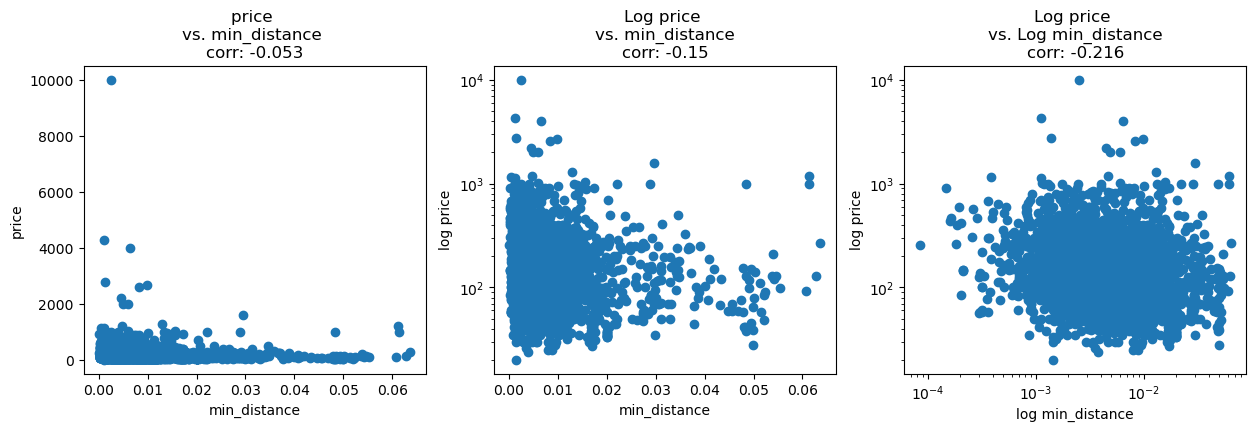

In [234]:
# PLot the price versus the minimum distance to a T-stop
plot_vs_log(lstn['min_distance'], lstn.price)